In [2]:
# Import dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import json

from splinter import Browser
from bs4 import BeautifulSoup as BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager

In [3]:
# Use splinter to setup the browser executable
executable_path = {"executable_path": ChromeDriverManager().install()}
browser = Browser("chrome", **executable_path, headless=False)

## 2. visit the Mars Temperature Data Links to an external Data site.

In [4]:
# Browser will auto visit to the URL
url = "https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html"
browser.visit(url)
html = browser.html
soup = BeautifulSoup(html, "html.parser")

## 3. Scrape the data in the HTML table.

In [5]:
# Search for the html table with data
html_table = soup.find("table", class_="table")

In [23]:
# Search for the header
html_table_header = html_table.find_all("th")

html_headers=[]
for header_element in html_table_header:
    title=header_element.text
    html_headers.append(title)
    
html_headers

['id', 'terrestrial_date', 'sol', 'ls', 'month', 'min_temp', 'pressure']

## 4. Assemble the scraped data into a Pandas DataFrame.

In [49]:
# Turn into pandas dataframe
scraped_df=pd.DataFrame(columns=html_headers)

# Find scraped rows
for rows in html_table.find_all("tr",class_="data-row"):
        scraped_data = rows.find_all("td")
        row_data=[cell.text.strip() for cell in scraped_data]
        lenghth=len(scraped_df)
        scraped_df.loc[lenghth]=row_data
        
scraped_df.head(5)

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
1,13,2012-08-17,11,156,6,-76.0,740.0
2,24,2012-08-18,12,156,6,-76.0,741.0
3,35,2012-08-19,13,157,6,-74.0,732.0
4,46,2012-08-20,14,157,6,-74.0,740.0


In [34]:
# Save df as a csv file
scraped_df.to_csv("Resources/mars_pt2.csv")

## 5. Examine the data types of all the DataFrame columns.

In [50]:
# Examine data types
scraped_df.dtypes

id                  object
terrestrial_date    object
sol                 object
ls                  object
month               object
min_temp            object
pressure            object
dtype: object

In [53]:
# Change data types to the correct dtypes
scraped_df.astype({'id': 'int32'}).dtypes
scraped_df.astype({'terrestrial_date': 'datetime64[ns]'}).dtypes
scraped_df.astype({'sol': 'int32'}).dtypes
scraped_df.astype({'ls': 'int32'}).dtypes
scraped_df.astype({'month': 'int32'}).dtypes
scraped_df.astype({'min_temp': 'float64'}).dtypes
scraped_df.astype({'pressure': 'float64'}).dtypes

id                           int32
terrestrial_date    datetime64[ns]
sol                          int32
ls                           int32
month                        int32
min_temp                   float64
pressure                   float64
dtype: object

## 6. How many months exist on Mars?

In [56]:
# How many months exist on Mars?
no_of_months=scraped_df['month'].nunique()
print(f'On Mars, there are a total of {no_of_months} months.')

On Mars, there are a total of 12 months.


## 7. How many Martian (and not Earth) days worth of data exist in the scraped dataset?

In [57]:
# How many Martian days worth of data exist in the scraped dataset?
martian_days=scraped_df['sol'].nunique()
print(f'There are {martian_days} unique number of days in the scraped dataset.')

There are 1867 unique number of days in the scraped dataset.


## 8. What are the coldest and the warmest months on Mars (at the location of Curiosity)?

In [82]:
# What are the coldest and the warmest months on Mars (at the location of Curiosity)?
# Find the average temps of each month

average_temperature=[]

for i in range(1,no_of_months+1):
    weather_per_month={"month #":"","average temperature":""}
    avg_min_temp_month=scraped_df.loc[scraped_df['month']==i]['min_temp'].mean()
    round_avg_min_temp_month = round(avg_min_temp_month,0)
    weather_per_month["month #"] = i
    weather_per_month["average temperature"] = round_avg_min_temp_month
    average_temperature.append(weather_per_month)    

print(average_temperature)  


[{'month #': 1, 'average temperature': -77.0}, {'month #': 2, 'average temperature': -80.0}, {'month #': 3, 'average temperature': -83.0}, {'month #': 4, 'average temperature': -83.0}, {'month #': 5, 'average temperature': -79.0}, {'month #': 6, 'average temperature': -75.0}, {'month #': 7, 'average temperature': -72.0}, {'month #': 8, 'average temperature': -68.0}, {'month #': 9, 'average temperature': -69.0}, {'month #': 10, 'average temperature': -72.0}, {'month #': 11, 'average temperature': -72.0}, {'month #': 12, 'average temperature': -74.0}]


In [86]:
json_mars_avg_temps = json.dumps(average_temperature)
# Save the json file just created as a pandas df
monthly_temps_df=pd.read_json(json_mars_avg_temps)
# Sort by avg temp from lowest to highest
monthly_temps_df.sort_values(by='average temperature', ascending=True)

,month #,average temperature
2,3,-83
3,4,-83
1,2,-80
4,5,-79
0,1,-77
5,6,-75
11,12,-74
6,7,-72
9,10,-72
10,11,-72


In [93]:
# show coldest and hottest months on Mars
min_temp = monthly_temps_df['average temperature'].min()
max_temp = monthly_temps_df['average temperature'].max()
print(f'On Mars, the coldest month appears to be month 3 at the temperature of {min_temp}, and the warmest is month 8 at the temperature of {max_temp}')

On Mars, the coldest month appears to be month 3 at the temperature of -83, and the warmest is month 8 at the temperature of -68


Text(0.5, 1.0, 'Avg Temperature on Mars by Month')

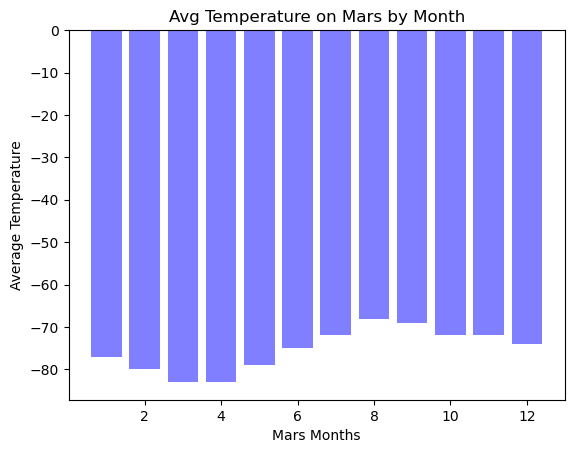

In [102]:
# Plot monthly_temps_df as a bar chart
plt.bar(monthly_temps_df['month #'],monthly_temps_df['average temperature'], color='b', alpha= 0.5)

# Create labels for the x and y axes.
plt.xlabel("Mars Months")
plt.ylabel("Average Temperature")

# Create title 
plt.title('Avg Temperature on Mars by Month')

## 9. Which months have the lowest and the highest atmospheric pressure on Mars?

In [97]:

# Find the average pressure of each month
months_df=scraped_df.groupby('month')
pressure_by_month_df=months_df.mean().loc[:,['pressure']]
# Sort by avg pressure from lowest to highest
pressure_by_month_df.sort_values(by='pressure', ascending=True)

,pressure
month,
6,745.054422
5,748.557047
7,795.105634
4,806.329897
12,842.156627
11,857.014493
1,862.488506
8,873.829787
3,877.322917


In [98]:
# show highest and lowest pressure months on Mars
lowest_pressure = pressure_by_month_df['pressure'].min()
highest_pressure = pressure_by_month_df['pressure'].max()
print(f'On Mars, the lowest pressure month appears to be month 6 at the pressure of {lowest_pressure}, and the highest pressure is month 9 at the amount of {highest_pressure}')

On Mars, the lowest pressure month appears to be month 6 at the pressure of 745.0544217687075, and the highest pressure is month 9 at the amount of 913.3059701492538


Text(0.5, 1.0, 'Avg Pressure on Mars by Month')

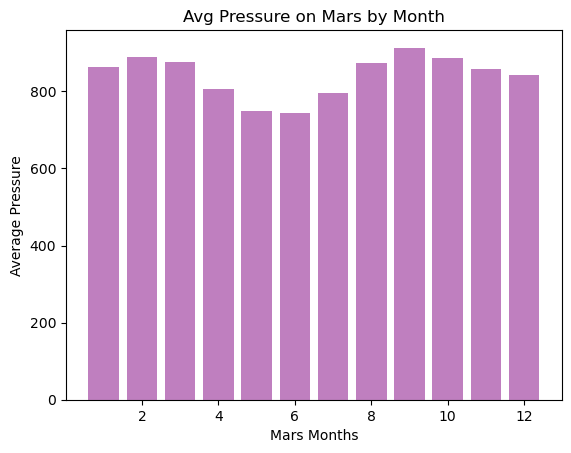

In [115]:
# Plot pressure_by_month_df as a bar chart
mths = range(1, 13)
plt.bar(mths,pressure_by_month_df['pressure'], color='purple', alpha= 0.5)

# Create labels for the x and y axes.
plt.xlabel("Mars Months")
plt.ylabel("Average Pressure")

# Create title 
plt.title('Avg Pressure on Mars by Month')

## Export the DataFrame to a CSV file.

In [118]:
# Save df as a csv file
scraped_df.to_csv("Resources/mars_pt2.csv")